# SVD в рекомендательных системах

# Rank One алгоритм при добавлении нового пользователя/айтема

In [1]:
!pip install animus

In [2]:
from abc import ABC, abstractmethod
from collections import defaultdict
from dataclasses import dataclass, field
from pprint import pprint
from typing import Any, Callable, Iterable, NamedTuple, Set, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sps
import seaborn as sns
import torch
from animus import ICallback, IExperiment
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sns.set(rc={"figure.figsize": (15, 5)})

In [3]:
import multiprocessing
import os

os.environ["OMP_NUM_THREADS"] = "1"
multiprocessing.set_start_method("fork")

## 1. Скачиваем данные

Взяли датасет MovieLens 10M. Это один из самых известных датасетов для исследования рекомендательных моделей. Достаточно много данных и в открытом доступе. Идеально для экспериментов

Признаки:
- `user` - пользователь сервиса
- `item` - id фильмов на сервисе
- рейтинг `user` для `item`. Рейтинг — explicit величина, которая принимает значения от 0 до 5
- метадата для фильмов

In [4]:
!wget https://files.grouplens.org/datasets/movielens/ml-10m.zip
!unzip -uo ml-10m.zip -d data
# Приведем к формату csv ratings
!awk 'BEGIN { print "user,item,values,timestamp" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/ratings.dat > data/ml-10M100K/ratings.csv
# Приведем к формату csv movies
!awk 'BEGIN { print "item,title,genres" } { gsub(/::/, ",", $0); print $0 }' data/ml-10M100K/movies.dat > data/ml-10M100K/movies.csv

--2023-11-06 17:15:05--  https://files.grouplens.org/datasets/movielens/ml-10m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65566137 (63M) [application/zip]
Saving to: ‘ml-10m.zip’

ml-10m.zip          100%[===================>]  62.53M  37.9MB/s    in 1.7s    

2023-11-06 17:15:08 (37.9 MB/s) - ‘ml-10m.zip’ saved [65566137/65566137]

Archive:  ml-10m.zip
   creating: data/ml-10M100K/
  inflating: data/ml-10M100K/allbut.pl  
  inflating: data/ml-10M100K/movies.dat  
  inflating: data/ml-10M100K/ratings.dat  
  inflating: data/ml-10M100K/README.html  
  inflating: data/ml-10M100K/split_ratings.sh  
  inflating: data/ml-10M100K/tags.dat  


## 2. Смотрим на данные

In [5]:
ratings = pd.read_csv("data/ml-10M100K/ratings.csv")
ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings.head().T

,0,1,2,3,4
user,1,1,1,1,1
item,122,185,231,292,316
values,5.0,5.0,5.0,5.0,5.0
timestamp,1996-08-02 11:24:06,1996-08-02 10:58:45,1996-08-02 10:56:32,1996-08-02 10:57:01,1996-08-02 10:56:32


In [6]:
ratings.shape, ratings.user.unique().shape, ratings.item.unique().shape

((10000054, 4), (69878,), (10677,))

### 2.1 Посмотрим на распределение рейтингов в данных

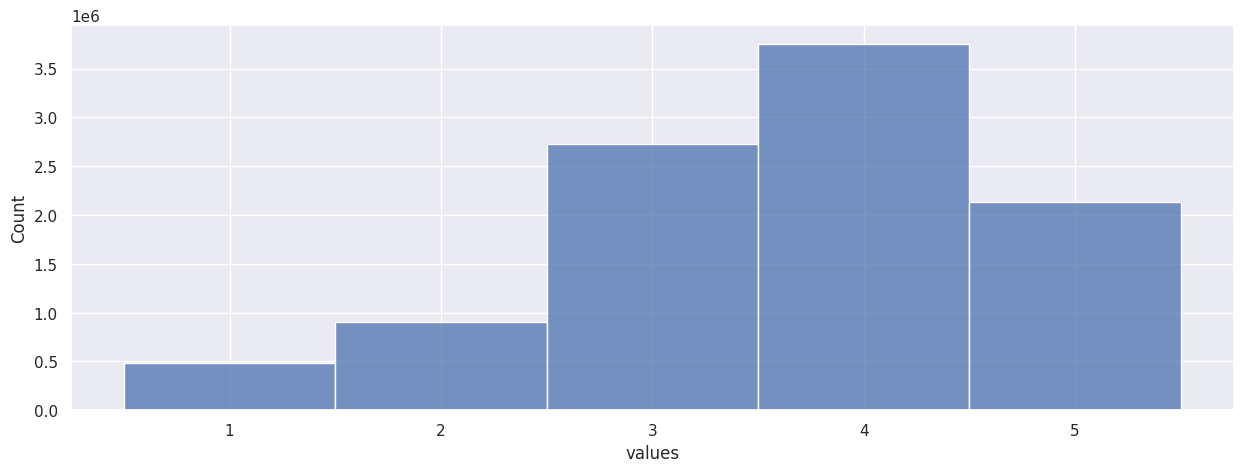

In [ ]:
sns.histplot(data=ratings["values"], binwidth=1)
plt.show()

### 2.2 Построим Rating Distribution

Rating Distribution -- график, который показывает отношение количества рейтингов к количеству юзеров. Он отлично подходит, чтобы визуализировать popularity-skew в данных. По оси y располагаем количество рейтингов, выраженное в процентах от общего количества. По оси x — айтемы сортированные в порядке убывания по количеству рейтингов на них. Ну и также ставим для них в качестве id — процент.

In [7]:
def rating_distribution(column: str) -> None:
    # Compute
    ratings_dist = ratings[column].value_counts(normalize=True).reset_index()
    ratings_dist.columns = [column, "num_ratings_percent"]
    step = 1 / (ratings_dist.shape[0] - 1)
    ratings_dist[f"{column}_percent"] = np.arange(0, 1 + step, step) * 100
    ratings_dist["num_ratings_percent"] = (
        np.cumsum(ratings_dist["num_ratings_percent"]) * 100
    )
    # Plot
    fig, ax = plt.subplots()
    sns.lineplot(
        data=ratings_dist, x=f"{column}_percent", y="num_ratings_percent", ax=ax
    )
    ax.set_xlim(0, 100)
    ax.set_xticks(range(0, 101, 2))
    ax.set_title("Rating Distribution")
    plt.show()

Для `item`:

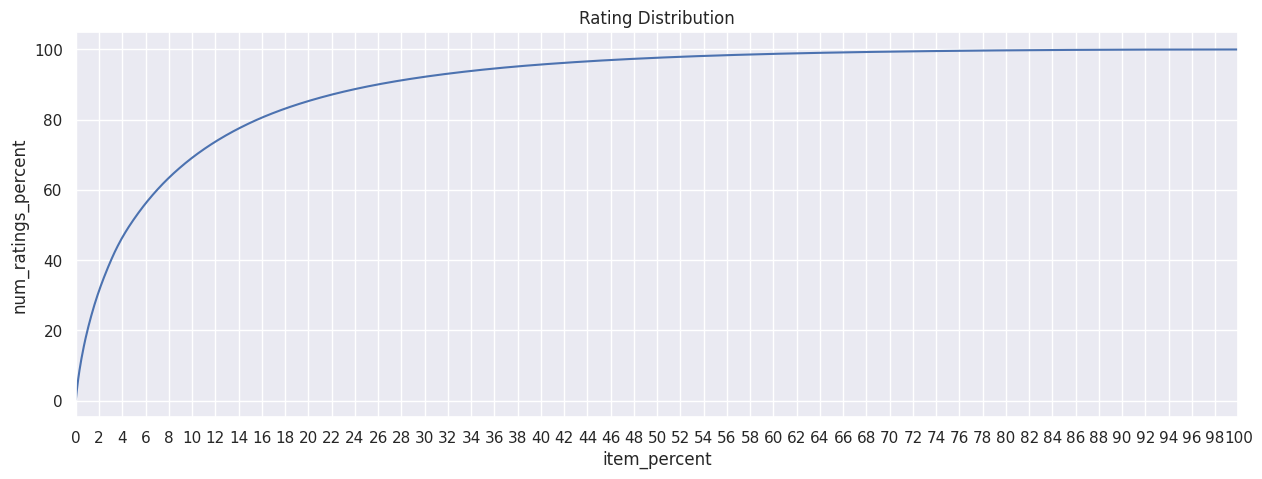

In [ ]:
rating_distribution(column="item")

То есть, например, 80% рейтингов было выставлено всего 16-ти процентам фильмов

Для `user`:

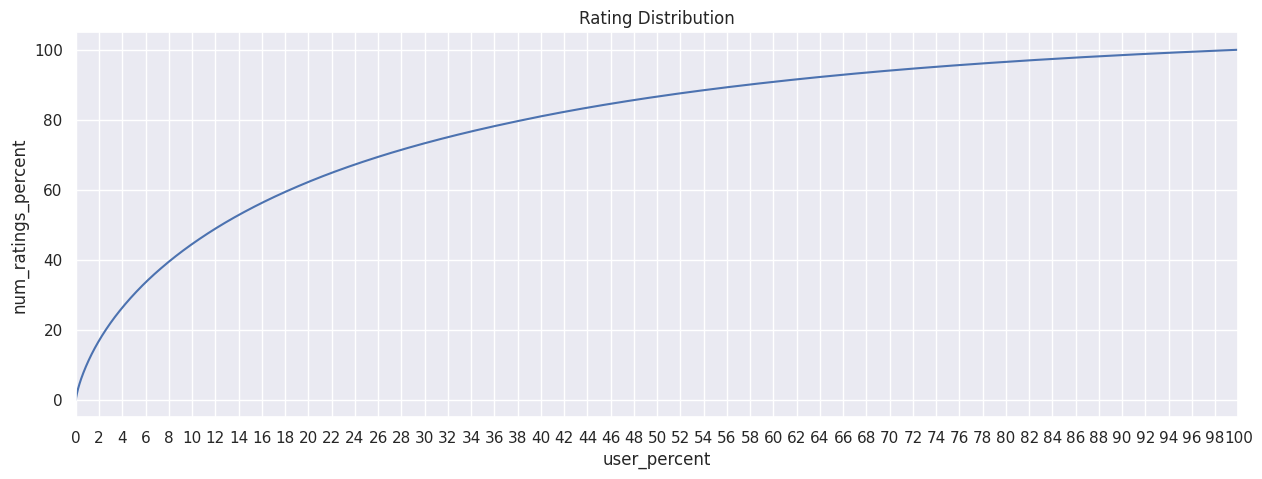

In [ ]:
rating_distribution(column="user")

60% рейтингов высталено 18-ю процентами пользователей (просто объяснения что значит, что точка принадлежит графику)

## 3. Preprocessing

- **valid_items**
    - получим элементы, которые встречаются реже чем threshold. Полезно, чтобы исключить супер популярные айтемы и активных юзеров.
- **filter_ratings**
    - оставим только рейтинги выше `min_rating` (полезно если хотим сделать implicit датасет)
    - оставим users и items, которые встречаются не реже `min_user_count`, `min_item_count` соответственно.

In [8]:
from typing import Union


class CleanData:
  def __init__(self,
               data: pd.DataFrame):
    self.data = data


  def valid_elements(self,
                     column: str,
                     threshold: float = 0.2
                    ) -> Set[int]:
      """
      Method remover top unique values of input column
        column: column which we want to clean from unvalid data
        treshold: which percent of top walues we wanna remove
      """
      rating_dist = self.data[column].value_counts().reset_index()
      cut_off = round(threshold * rating_dist.shape[0]) + 1
      return set(rating_dist.index[cut_off:])


  def get_count(self,
                column: str
              ) -> pd.DataFrame:
      """
        column: which column to gruoup by
      """
      grouped_by_column = self.data.groupby(column, as_index=False)
      return grouped_by_column.size()


  def _filter_ratings(self,
                     data: pd.DataFrame,
                     min_rating: float = 3.0,
                     min_user_count: int = 3,
                     min_item_count: int = 3,
                   ) -> pd.DataFrame:
      """
      Method cut unnecessary (outbreak) data, like low marks and inactive users
        min_rating: all marks with lower rating would not be taken in accout
        min_user_count: min number of users that had marked an element
        min_item_count: min number of elements marked by user
      """
      if min_rating is not None:
          data = data.loc[data["values"] > min_rating]

      if min_item_count > 0:
          itemcount = self.get_count(column="item")
          data = data.loc[
              data["item"].isin(itemcount.item[itemcount["size"] >= min_item_count])
        ]
      if min_user_count > 0:
          usercount = self.get_count(column="user")
          data = data.loc[
              data["user"].isin(usercount.user[usercount["size"] >= min_user_count])
          ]
      return data


  def filter_ratings(self,
                     min_rating: float = 3.0,
                     min_user_count: int = 3,
                     min_item_count: int = 3,
                     remove_top_items: Union[bool, float] = True,
                  ) -> pd.DataFrame:
      """
        min_rating: all marks with lower rating would not be taken in accout
        min_user_count: min number of users that had marked an element
        min_item_count: min number of elements marked by user
        remove_top_items: percent of top items which we wanna to remove
      """
      data = self.data.copy()

      if float(remove_top_items) > 0:
          if type(remove_top_items) == float:
            valid_items = self.valid_elements(column="item", threshold=remove_top_items)
            print('tops')
          else:
            valid_items = self.valid_elements(column="item")
          data = data.loc[data["item"].isin(valid_items)]

      while True:
          cur_num_rows = data.shape[0]
          data = self._filter_ratings(data, min_rating, min_user_count, min_item_count)
          new_num_rows = data.shape[0]
          if cur_num_rows == new_num_rows:
              break
      return data

In [9]:
cleaner = CleanData(ratings)


implicit_filtered_ratings = cleaner.filter_ratings().reset_index(drop=True)
print(f"Before: {ratings.shape}; After: {implicit_filtered_ratings.shape}")

explicit_filtered_ratings = cleaner.filter_ratings(min_rating=None).reset_index(drop=True)
print(f"Before: {ratings.shape}; After: {explicit_filtered_ratings.shape}")

Before: (10000054, 4); After: (2338552, 4)
Before: (10000054, 4); After: (3998461, 4)


### Encoder для данных

Мы, когда чистили датасет удалили часть юзеров и часть айтемов, теперь хотим опять сделать нормальную нумерацию (была же сквозная, а мы из нее часть элементов выбили)

In [10]:
from sklearn.preprocessing import LabelEncoder

for col in ['user', 'item']:
  encoder = LabelEncoder()

  explicit_filtered_ratings[col] = encoder.fit_transform(explicit_filtered_ratings[col])
  implicit_filtered_ratings[col] = encoder.transform(implicit_filtered_ratings[col])

In [ ]:
implicit_filtered_ratings

,user,item,values,timestamp
0,0,1260,4.0,2006-11-30 11:19:50
1,0,1529,4.5,2006-01-01 00:38:35
2,0,2373,4.0,2006-11-30 11:18:46
3,0,2515,4.0,2006-01-01 00:38:44
4,0,2829,4.5,2005-12-03 00:53:20
...,...,...,...,...
2338547,47536,1652,4.0,2000-11-15 13:37:47
2338548,47536,1655,4.0,2000-11-15 13:33:54
2338549,47536,1656,4.0,2000-11-15 13:26:26
2338550,47536,2894,4.0,2000-11-15 13:24:52


### 3.3 Split

Тестовая выборка - out of time, иначе говоря, берем последний год из базы как тестовую выборку, а на остальном будем обучаться. Обычно такая же ситуация и в реальности: у нас есть какая-то история, а мы хотим предсказать что в будущем пользователь захочет посмотреть и порекомендовать ему это

Также для нашей задачи выкинем одного и двух пользователей из исходного датасета. То есть у нас будет три датасета: со всеми пользователями, без одного и без двух. Это нужно для проверки скорости работы прямого пересчета SVD при добавление одного-двух пользователей и скорости работы алгоритма, который пересчитывает SVD по-умному, основываясь на разложении, которое было для $(n-1)$-ого пользователя. Выкидывать будем последних пользователей, что encoding не поехал

In [11]:
def remove_users(dataset: pd.DataFrame,
                 n: int = 2
                ) -> pd.DataFrame:
  """
  Method to remove users from dataset to test adding them to existing svd
    dataset: out dataset from which we wanna remove users
    n: number of users we wanna remove
  """
  to_remove = dataset['user'].sort_values().unique()[-n:]
  main_dataset = dataset[~dataset['user'].isin(to_remove)]
  removed_users = dataset[dataset['user'].isin(to_remove)]

  return [main_dataset, removed_users]

In [12]:
def remove_items(dataset: pd.DataFrame,
                 n: int = 1
                ) -> pd.DataFrame:
  """
  Method to remove items from dataset to test adding them to existing svd
    dataset: out dataset from which we wanna remove items
    n: number of items we wanna remove
  """
  to_remove = dataset['item'].sort_values().unique()[-n:]
  main_dataset = dataset[~dataset['item'].isin(to_remove)]
  removed_items = dataset[dataset['item'].isin(to_remove)]

  return [main_dataset, removed_items]


In [13]:
explicit_filtered_remove2, explicit_removed2_dataset = remove_users(explicit_filtered_ratings)
implicit_filtered_remove2, implicit_removed2_dataset = remove_users(implicit_filtered_ratings)

In [ ]:
explicit_filtered_remove2

,user,item,values,timestamp
0,0,1260,4.0,2006-11-30 11:19:50
1,0,1529,4.5,2006-01-01 00:38:35
2,0,2373,4.0,2006-11-30 11:18:46
3,0,2515,4.0,2006-01-01 00:38:44
4,0,2829,4.5,2005-12-03 00:53:20
...,...,...,...,...
3998392,47535,5112,3.5,2005-03-23 02:37:08
3998393,47535,5741,2.5,2005-03-23 02:36:05
3998394,47535,5780,3.0,2005-03-23 02:40:01
3998395,47535,5806,4.5,2005-03-23 02:33:02


In [ ]:
explicit_removed2_dataset

,user,item,values,timestamp
3998397,47536,11,3.0,2000-11-15 13:20:35
3998398,47536,31,1.0,2000-11-16 13:53:37
3998399,47536,200,4.0,2000-11-15 13:20:50
3998400,47536,210,3.0,2000-11-15 13:28:54
3998401,47536,233,4.0,2000-11-15 13:20:35
...,...,...,...,...
3998456,47536,1656,4.0,2000-11-15 13:26:26
3998457,47536,2894,4.0,2000-11-15 13:24:52
3998458,47537,158,5.0,1998-12-02 05:52:48
3998459,47537,202,2.0,1998-12-02 05:53:36


In [ ]:
explicit_filtered_ratings

,user,item,values,timestamp
0,0,1260,4.0,2006-11-30 11:19:50
1,0,1529,4.5,2006-01-01 00:38:35
2,0,2373,4.0,2006-11-30 11:18:46
3,0,2515,4.0,2006-01-01 00:38:44
4,0,2829,4.5,2005-12-03 00:53:20
...,...,...,...,...
3998456,47536,1656,4.0,2000-11-15 13:26:26
3998457,47536,2894,4.0,2000-11-15 13:24:52
3998458,47537,158,5.0,1998-12-02 05:52:48
3998459,47537,202,2.0,1998-12-02 05:53:36


In [14]:
explicit_filtered_remove1, explicit_removed1_dataset = remove_users(explicit_filtered_ratings, n=1)
implicit_filtered_remove1, implicit_removed1_dataset = remove_users(implicit_filtered_ratings, n=1)

In [15]:
ts_split = {
    "implicit": implicit_filtered_ratings["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_ratings["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_full = {}
for key, dataset in (
    ("implicit", implicit_filtered_ratings),
    ("explicit", explicit_filtered_ratings),
):
    datasets_full[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_full[key]["valid"] = datasets_full[key]["valid"].loc[
        datasets_full[key]["valid"].user.isin(datasets_full[key]["train"].user.unique())
    ]

In [16]:
ts_split = {
    "implicit": implicit_filtered_remove1["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_remove1["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_minus1 = {}
for key, dataset in (
    ("implicit", implicit_filtered_remove1),
    ("explicit", explicit_filtered_remove1),
):
    datasets_minus1[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_minus1[key]["valid"] = datasets_minus1[key]["valid"].loc[
        datasets_minus1[key]["valid"].user.isin(datasets_minus1[key]["train"].user.unique())
    ]

In [17]:
ts_split = {
    "implicit": implicit_filtered_remove2["timestamp"].max()
    - pd.Timedelta(365, "days"),
    "explicit": explicit_filtered_remove2["timestamp"].max()
    - pd.Timedelta(365, "days"),
}
datasets_minus2 = {}
for key, dataset in (
    ("implicit", implicit_filtered_remove2),
    ("explicit", explicit_filtered_remove2),
):
    datasets_minus2[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_minus2[key]["valid"] = datasets_minus2[key]["valid"].loc[
        datasets_minus2[key]["valid"].user.isin(datasets_minus2[key]["train"].user.unique())
    ]

In [ ]:
datasets_minus1

{'implicit': {'train':           user  item  values           timestamp
  0            0  1260     4.0 2006-11-30 11:19:50
  1            0  1529     4.5 2006-01-01 00:38:35
  2            0  2373     4.0 2006-11-30 11:18:46
  3            0  2515     4.0 2006-01-01 00:38:44
  4            0  2829     4.5 2005-12-03 00:53:20
  ...        ...   ...     ...                 ...
  2338546  47536  1633     4.0 2000-11-15 13:41:22
  2338547  47536  1652     4.0 2000-11-15 13:37:47
  2338548  47536  1655     4.0 2000-11-15 13:33:54
  2338549  47536  1656     4.0 2000-11-15 13:26:26
  2338550  47536  2894     4.0 2000-11-15 13:24:52
  
  [2128722 rows x 4 columns],
  'valid':           user  item  values           timestamp
  889         20  1412     4.5 2008-04-20 05:35:35
  925         20  3178     4.0 2008-04-20 05:33:46
  1714        42  1286     4.0 2008-06-19 23:47:17
  1715        42  1528     5.0 2008-06-19 23:57:50
  1718        42  2807     5.0 2008-06-19 23:48:56
  ...        ...   

In [18]:
I = 0

In [19]:
def make_sparse(dataset: pd.DataFrame,
                binary: bool = False,
              ) -> sps.csr_matrix:
    """
    Method for creating matrix, that will have item and user unique labels as axises and will be filled by scores (that user gived to item)
      dataset: our dataset
      binary: flag if we want to put just 1 instead of scores
    """
    shape = (explicit_filtered_ratings['user'].nunique(), explicit_filtered_ratings['item'].nunique() - I)
    values = dataset["values"].to_numpy()
    values = np.ones_like(values) if binary else values
    row = np.array(dataset["user"].to_numpy())
    column = np.array(dataset["item"].to_numpy())
    return sps.csr_matrix(
                          (values, (row, column)),
                          shape=shape
                          )


def build_sparse_datasets(train: pd.DataFrame,
                          valid: pd.DataFrame,
                          binary: bool = True,
                        ) -> dict[str, dict[str, sps.csr_matrix]]:
    """
    Wrapper for make_sparse method
    """
    train_sparse = make_sparse(train, binary=binary)
    valid_sparse = make_sparse(valid, binary=binary)
    train_mask, valid_mask = (
        train_sparse.getnnz(axis=-1) > 0,
        valid_sparse.getnnz(axis=-1) > 0,
    )
    return {
        "train": {
            "source": train_sparse[train_mask],
            "target": train_sparse[train_mask],
        },
        "valid": {
            "source": valid_sparse[valid_mask],
            "target": valid_sparse[valid_mask],
        },
    }

In [20]:
explicit_full_datasets = build_sparse_datasets(
    **datasets_full["explicit"], binary=False
)
implicit_full_datasets = build_sparse_datasets(
    **datasets_full["implicit"], binary=True
)
print("Explicit")
pprint(explicit_full_datasets)
print("Implicit")
pprint(implicit_full_datasets)

Explicit
{'train': {'source': <43239x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679915 stored elements in Compressed Sparse Row format>,
           'target': <43239x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679915 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42583x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128723 stored elements in Compressed Sparse Row format>,
           'target': <42583x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128723 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

In [21]:
explicit_minus1_datasets = build_sparse_datasets(
    **datasets_minus1["explicit"], binary=False
)
implicit_minus1_datasets = build_sparse_datasets(
    **datasets_minus1["implicit"], binary=True
)
print("Explicit")
pprint(explicit_minus1_datasets)
print("Implicit")
pprint(implicit_minus1_datasets)

Explicit
{'train': {'source': <43238x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679912 stored elements in Compressed Sparse Row format>,
           'target': <43238x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679912 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42582x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128722 stored elements in Compressed Sparse Row format>,
           'target': <42582x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128722 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

In [22]:
explicit_minus2_datasets = build_sparse_datasets(
    **datasets_minus2["explicit"], binary=False
)
implicit_minus2_datasets = build_sparse_datasets(
    **datasets_minus2["implicit"], binary=True
)
print("Explicit")
pprint(explicit_minus2_datasets)
print("Implicit")
pprint(implicit_minus2_datasets)

Explicit
{'train': {'source': <43237x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679851 stored elements in Compressed Sparse Row format>,
           'target': <43237x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 3679851 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>,
           'target': <2369x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 56288 stored elements in Compressed Sparse Row format>}}
Implicit
{'train': {'source': <42581x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128685 stored elements in Compressed Sparse Row format>,
           'target': <42581x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 2128685 stored elements in Compressed Sparse Row format>},
 'valid': {'source': <2261x6196 sparse matrix of type '<class 'numpy.float64'>'
	with 34365 stored elements in Comp

### 3.4 Готовим лоадеры для данных

Сложим все аккуратно по батчам для удобства дальнейшего обучения

In [23]:
class MovieLensDataset(Dataset):
    def __init__(self, source: sps.csc_matrix, target: sps.csr_matrix = None) -> None:
        self._source = source
        self._target = target

    def __len__(self):
        return self._source.shape[0]

    def __getitem__(self, idx: int) -> dict[str, np.ndarray]:
        item = {"source": self._source[idx]}
        if self._target is not None:
            item["target"] = self._target[idx]
        return item

In [24]:
class MovieLensCollator:
    def __call__(
        self, instances: Iterable[dict[str, sps.csr_matrix]]
    ) -> dict[str, torch.Tensor]:
        batch = self._make_batch(instances)
        for key, tensor in batch.items():
            batch[key] = (
                self._to_sparse(tensor).to_dense().float()
                if isinstance(tensor[0], sps.csr_matrix)
                else torch.Tensor(tensor)
            )
        return dict(batch)

    @staticmethod
    def _make_batch(
        instances: Iterable[dict[str, sps.csr_matrix]]
    ) -> dict[str, list[sps.csr_matrix]]:
        tensor_dict = defaultdict(list)
        for instance in instances:
            for field, tensor in instance.items():
                tensor_dict[field].append(tensor)
        return tensor_dict

    @staticmethod
    def _to_sparse(tensor: list[sps.csr_matrix]) -> torch.sparse.Tensor:
        tensor = sps.vstack(tensor)
        values = torch.from_numpy(tensor.data)
        indices = torch.from_numpy(np.vstack(tensor.nonzero())).long()
        sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
        return sparse_tensor

## 4. Наши методы

###  Sparse Model и Runner

#### Sparse Model

Сделаем базовый класс, он зафиксирует тот факт, что модель состоит из 2 функций:
- Обучение — `.fit()`. Каждая модель обучается только на `train.source` части из датасетов.
- Инфер — `.predict_proba()`. Делаем инфер на батче данных из `(train|valid).source` и сравниваем с ответами в `(train|valid).target`, если добавили callback с метриками. Ответ каждой модели — словарь. Мы решили остановиться на dict только с одним ключом **logits**.

И еще тот факт, что у нас данные на cpu храниться будут

И да ещё один важный момент. У каждой модели есть параметр `remove_seen`. С помощью него из предсказний модели, можно убрать айтемы, которые юзер видел во время обучения. В итоге мы всегда будем рекомендовать только что-то новое для клиентов.

#### Runner

Runner решает только одну задачу — прогон модели на данных. `fit` делаем на всех данных, а `predict_proba` батчевым образом, чтобы сэкономить на памяти.

In [25]:
import numpy as np
import scipy.linalg as la

In [26]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [27]:
class SparseModel(ABC):
    def __init__(self, remove_seen: bool = True) -> None:
        self.remove_seen = remove_seen
        self.device = torch.device("cpu")

    @abstractmethod
    def fit(self, data: sps.csr_matrix) -> None:
        pass

    @abstractmethod
    def predict_proba(self, batch: dict[str, Any]) -> dict[str, torch.Tensor]:
        pass

    def to(self, device: torch.device) -> "SparseModel":
        self.device = device
        return self

In [28]:
class SparseRunner(IExperiment):
    def __init__(
                self,
                model: SparseModel,
                seed: int = 13,
                batch_size: int = 32,
                device: torch.device = torch.device("cpu"),
                callbacks: dict[str, ICallback] = None,
                target_threshold: float = 0.0,
              ) -> None:
        super().__init__()
        self.seed = seed
        self.model = model.to(device)
        self.device = device
        self.callbacks = callbacks or defaultdict(None)
        self._batch_size = batch_size
        self._target_threshold = target_threshold
        # Extra variables
        self.batch_output: dict[str, torch.Tensor] = None
        self.batch_target: torch.Tensor = None

    def run_dataset(self) -> None:
        if self.is_train_dataset:
            self.model.fit(self.dataset["source"])
        self.dataset = tqdm(
            DataLoader(
                MovieLensDataset(**self.dataset),
                collate_fn=MovieLensCollator(),
                batch_size=self._batch_size,
                shuffle=True,
                num_workers=1,
                pin_memory=True,
            ),
            desc=f"Iterating {self.dataset_key}",
        )
        # Remove seen items only for validation
        self.model.remove_seen = not self.is_train_dataset
        super().run_dataset()

    def run_batch(self) -> None:
        self.batch = {k: v.to(self.device) for k, v in self.batch.items()}
        self.batch_target = self.batch["target"].gt(self._target_threshold).float()
        self.batch_output = self.model.predict_proba(self.batch)

    def run(self, datasets: dict[str, dict[str, sps.csr_matrix]]) -> None:
        self.datasets = datasets
        super().run()

In [29]:
dataset_example_train = MovieLensDataset(**implicit_full_datasets["train"])

In [30]:
loader_example = DataLoader(
    dataset_example_train,
    collate_fn=MovieLensCollator(),
    batch_size=32,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

### 4.1 Baseline

Модель TopPopular. Получаем список самых популярных айтемов по суммированию рейтингов и рекомендуем всем эти вот самые популярные айтемы (тут не будет никакой разницы между explicit и implicit)

In [31]:
class TopPopularModel(SparseModel):
    def __init__(self,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self._stats = {}

    def fit(self,
            data: sps.csr_matrix
          ) -> None:
        self._logits = (
          torch.from_numpy(np.array(data.sum(axis=0), dtype=np.float32))
          .view(-1)
          .to(self.device)
        )
        self._stats["item_freq"] = self._logits

    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = self._logits.repeat(batch["source"].size(0), 1)
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [ ]:
top_popular_full = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_full.run(implicit_full_datasets)
print("Explicit")
top_popular_full.run(explicit_full_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 73.86it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:00<00:00, 76.38it/s]


In [ ]:
top_popular_minus1 = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_minus1.run(implicit_minus1_datasets)
print("Explicit")
top_popular_minus1.run(explicit_minus1_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 76.25it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:01<00:00, 70.04it/s]


In [ ]:
top_popular_minus2 = SparseRunner(model=TopPopularModel(), device=device)

print("Implicit")
top_popular_minus2.run(implicit_minus2_datasets)
print("Explicit")
top_popular_minus2.run(explicit_minus2_datasets)

Implicit


Iterating train:   0%|          | 0/1331 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/71 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 71/71 [00:00<00:00, 73.75it/s]


Explicit


Iterating train:   0%|          | 0/1352 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/75 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 75/75 [00:00<00:00, 76.54it/s]


### 4.2 Built-in SVD

В `predict_proba` мы воспользуемся ортогональностью матриц $U \sim R^{\text{(num users) x (factors)}}$ и $V \sim R^{\text{(num items) x (factors)}}$. Благодаря этому инфер можно записать вот так: $\hat{r}_u = r_u \cdot V \cdot V^T$

Пользуемся встроенным методом разложения SVD, т.к. по скорости он значительно лучше, чем прописанный вручную. Если будет время, можно будет и вручную прописать. Тут полезно замерить время работы

На такой большой матрице SVD считается жутко долго, даже если передавать в scipy sparse матрицу, поэтому на всем датасете будем считать неполное SVD (128 главных компонент). Потом возьмем в трейн матрицу поменьше, чтобы посчитать полное SVD

In [32]:
import time

In [33]:
class Built_in_SvdModel(SparseModel):
    """
    factors: ~number of singular values that we compute
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                 factors: int,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self._factors = factors
        self.factors = {}
        self.svd = None


    def fit(self,
            data: sps.csr_matrix
          ) -> None:
        print(data.shape)
        start_time = time.time()
        u, sigma, vt = sps.linalg.svds(data, k=self._factors)
        print(u.shape, sigma.shape, vt.shape)
        end_time = time.time()
        self.computation_time = end_time - start_time
        print("--- %s seconds svd computation---" % (end_time - start_time))

        self.svd = [u, sigma, vt]

        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(vt).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [ ]:
built_in_svd_runner_full = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_full.run(implicit_full_datasets)
print("Explicit")
built_in_svd_runner_full.run(explicit_full_datasets)

Implicit
--- 5.880376100540161 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-18-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-18-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


Explicit
--- 8.967791318893433 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-18-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-18-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.64it/s]


In [ ]:
built_in_svd_runner_minus1 = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_minus1.run(implicit_minus1_datasets)
print("Explicit")
built_in_svd_runner_minus1.run(explicit_minus1_datasets)

Implicit
--- 6.376446485519409 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.57it/s]


Explicit
--- 9.0573570728302 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.17it/s]


In [ ]:
built_in_svd_runner_minus2 = SparseRunner(model=Built_in_SvdModel(factors = 128), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_minus2.run(implicit_minus2_datasets)
print("Explicit")
built_in_svd_runner_minus2.run(explicit_minus2_datasets)

Implicit
--- 5.362397909164429 seconds svd computation---


Iterating train:   0%|          | 0/84 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:01<00:00,  4.88it/s]


Explicit
--- 8.110839366912842 seconds svd computation---


Iterating train:   0%|          | 0/85 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-30-5dbb9ea315af>:29: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  sparse_tensor = torch.sparse.FloatTensor(indices, values, tensor.shape)
Iterating valid: 100%|██████████| 5/5 [00:00<00:00,  6.24it/s]


In [ ]:
built_in_svd_runner_minus2.model.svd[0].shape

(43237, 128)

Берем датасет поменьше - оставим 5000 пользователей (чтобы полное SVD посчитать)

In [34]:
explicit_small, explicit_small_removed = remove_users(explicit_filtered_ratings, n = 42537)
implicit_small, implicit_small_removed = remove_users(implicit_filtered_ratings, n = 42537)

In [ ]:
explicit_small

,user,item,values,timestamp
0,0,1260,4.0,2006-11-30 11:19:50
1,0,1529,4.5,2006-01-01 00:38:35
2,0,2373,4.0,2006-11-30 11:18:46
3,0,2515,4.0,2006-01-01 00:38:44
4,0,2829,4.5,2005-12-03 00:53:20
...,...,...,...,...
394692,5000,3614,4.5,2006-12-01 10:23:08
394693,5000,4172,0.5,2006-12-01 11:02:05
394694,5000,4724,0.5,2006-12-01 11:02:04
394695,5000,4940,4.0,2006-12-01 11:01:03


С этим датасетом надо проделать то же, что мы делали выше. Только SVD полное посчитать через np.linalg.svd

In [35]:
explicit_small_remove2, explicit_small_removed2 = remove_users(explicit_small)
implicit_small_remove2, implicit_small_removed2 = remove_users(implicit_small)

explicit_small_remove1, explicit_small_removed1= remove_users(explicit_small, n=1)
implicit_small_remove1, implicit_small_removed1 = remove_users(implicit_small, n=1)

In [36]:
ts_split = {
    "implicit": implicit_small["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small = {}
for key, dataset in (
    ("implicit", implicit_small),
    ("explicit", explicit_small),
):
    datasets_small[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small[key]["valid"] = datasets_small[key]["valid"].loc[
        datasets_small[key]["valid"].user.isin(datasets_small[key]["train"].user.unique())
    ]

ts_split = {
    "implicit": implicit_small_remove2["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small_remove2["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small_minus2 = {}
for key, dataset in (
    ("implicit", implicit_small_remove2),
    ("explicit", explicit_small_remove2),
):
    datasets_small_minus2[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small_minus2[key]["valid"] = datasets_small_minus2[key]["valid"].loc[
        datasets_small_minus2[key]["valid"].user.isin(datasets_small_minus2[key]["train"].user.unique())
    ]

ts_split = {
    "implicit": implicit_small_remove1["timestamp"].max()
    - pd.Timedelta(165, "days"),
    "explicit": explicit_small_remove1["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
datasets_small_minus1 = {}
for key, dataset in (
    ("implicit", implicit_small_remove1),
    ("explicit", explicit_small_remove1),
):
    datasets_small_minus1[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    datasets_small_minus1[key]["valid"] = datasets_small_minus1[key]["valid"].loc[
        datasets_small_minus1[key]["valid"].user.isin(datasets_small_minus1[key]["train"].user.unique())
    ]

In [37]:
explicit_small_datasets = build_sparse_datasets(
    **datasets_small["explicit"], binary=False
)
implicit_small_datasets = build_sparse_datasets(
    **datasets_small["implicit"], binary=True
)

explicit_small_datasets_minus2 = build_sparse_datasets(
    **datasets_small_minus2["explicit"], binary=False
)
implicit_small_datasets_minus2 = build_sparse_datasets(
    **datasets_small_minus2["implicit"], binary=True
)

explicit_small_datasets_minus1 = build_sparse_datasets(
    **datasets_small_minus1["explicit"], binary=False
)
implicit_small_datasets_minus1 = build_sparse_datasets(
    **datasets_small_minus1["implicit"], binary=True
)

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
noise = np.random.uniform(0, 0.1, (48000, 7000))

In [40]:
class Built_in_SvdModel(SparseModel):
    """
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                 remove_seen: bool = True
                ) -> None:
        super().__init__(remove_seen=remove_seen)
        self.factors = {}
        self.svd = None


    def fit(self,
            data: sps.csr_matrix
          ) -> None:
        start_time = time.time()
        A = data.todense()
        u, sigma, vt = la.svd(A + noise[:A.shape[0], :A.shape[1]], full_matrices=False)
        end_time = time.time()
        self.computation_time = end_time - start_time
        print("--- %s seconds svd computation---" % (end_time - start_time))

        self.svd = [vt.T, sigma.T, u.T] # сохраняем для транспонированной

        self.factors = {
            "user": torch.from_numpy(u.copy()).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(vt).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

In [ ]:
built_in_svd_runner_small_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_impicit.run(implicit_small_datasets)
print("Explicit")
built_in_svd_runner_small_explicit.run(explicit_small_datasets)

Implicit
--- 86.21878957748413 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


Explicit
--- 108.44053936004639 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


In [ ]:
built_in_svd_runner_small_minus2_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_minus2_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_minus2_impicit.run(implicit_small_datasets_minus2)
print("Explicit")
built_in_svd_runner_small_minus2_explicit.run(explicit_small_datasets_minus2)

Implicit
--- 88.54703283309937 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


Explicit
--- 110.48113179206848 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


In [ ]:
built_in_svd_runner_small_minus1_impicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
built_in_svd_runner_small_minus1_explicit = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)

print("Implicit")
built_in_svd_runner_small_minus1_impicit.run(implicit_small_datasets_minus1)
print("Explicit")
built_in_svd_runner_small_minus1_explicit.run(explicit_small_datasets_minus1)

Implicit
--- 90.33847284317017 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Explicit
--- 112.40744638442993 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


### 4.3 Rank-one SVD Model

runner.model - тут будет лежать обученная базовая модель, где уже посчитался svd (runner.model.svd). Нужно вот весь runner.model взять, подать в свой класс, а затем уже реализовывать добавление пользователя/айтема



In [41]:
import numpy as np
import scipy as sp
import time
from copy import copy

In [42]:
rounding_ndigits = 14 # Число знаков для сигм. Используется для сравнения с нулями и сравнения сигм
epsilon1 = 10**(-rounding_ndigits) # Для нахождения нулей

Определим функции для обновления SVD разложения при добавлении пользователя или айтема (строки или столбца)

In [43]:
def arrays_merge(a1, a2, decreasing=True, func=None):
    """
    Объединяет два отсортированных массива в один отсортированный массив.

    Inputs:
        a1 (list): Первый массив.
        a2 (list): Второй массив.
        decreasing (bool): Если True, выходной массив будет отсортирован по убыванию.
        func (callable, optional): Функция, которая применяется к элементам массива для сравнения.

    Returns:
        tuple: Кортеж, содержащий перестановку индексов и объединенный отсортированный массив.
    """
    # Если функция не предоставлена, используется тождественная функция.
    identity = lambda x: x
    key_func = func if func is not None else identity

    a1 = sorted(a1, key=key_func, reverse=decreasing)
    a2 = sorted(a2, key=key_func, reverse=decreasing)

    # Объединяем массивы
    combined = np.concatenate((a1, a2))
    # Вычисляем ключи для сортировки
    keys = np.array([key_func(x) for x in combined])

    # Определяем порядок сортировки (по возрастанию или по убыванию)
    if decreasing:
        sort_order = np.argsort(-keys)
    else:
        sort_order = np.argsort(keys)

    # Применяем перестановку для сортировки
    sorted_combined = combined[sort_order]

    # Корректируем индексы для второго массива
    perm = sort_order.copy()
    len_a1 = len(a1)
    perm[perm >= len_a1] -= len_a1

    return perm.tolist(), sorted_combined.tolist()

def find_roots(sigmas, m_vec):
    """
    Находит корни уравнения дополненной матрицы сингулярных значений

    Inputs:
        sigmas - матрица сингулярных значений размера (n*n), расположенные на диагонали.

        m_vec - дополнительный столбцовый вектор, который присоединяется справа к матрице Сигма.
                Должен быть размера (m*1)
    Returns:
        корни из собсвтенных значений в обратном порядке
    """

    # Создаем матрицу M, используя внешние произведения
    M = np.diag(sigmas**2) + np.outer(m_vec, m_vec)

    # Находим собственные значения матрицы M, которые являются квадратами искомых сингулярных значений
    sm = sp.linalg.eigh(M, eigvals_only=True, overwrite_a=True, check_finite=False)

    # Возвращаем корни из собственных значений в обратном порядке
    return np.sqrt(sm[::-1])

def SVD_upd_diag_equal_sigmas( sigmas, m_vec , new_col):
    """
    Это внутренняя функция, которая вызывается функцией SVD_upd_diag. Она анализирует
    наличие одинаковых сигм в наборе сигм и, если они есть, возвращает
    соответствующее унитарное преобразование, которое разделяет уникальные и равные
    сигмы. Это необходимо, потому что метод в SVD_upd_diag работает только для
    уникальных сигм. Также обнаруживает нули в векторе m_vec и выполняет соответствующую
    перестановку, если обнаружены эти нули. Когда добавляется новый столбец,
    исходная матрица квадратная, и обязательно должно выполняться условие sigma[-1] = 0 и
    m_vec[-1] != 0. Когда добавляется новая строка, исходная матрица не квадратная,
    и сигмы произвольны.

    Inputs:
        sigmas - сингулярные значения квадратной матрицы
        m_vec - дополнительный столбец, добавленный к квадратной диагональной матрице сингулярных
                векторов.
        new_col - указывает, какая задача решается. True, если изначально решалась
                  проблема добавления нового столбца, False, если добавляется новая строка.
    Returns:
        is_equal_sigmas - логическое значение, которое True, если есть одинаковые сигмы,
                          иначе False.
        uniq_length - количество уникальных сигм.
        U - унитарное преобразование, которое преобразует
            исходную матрицу (S + mm*) в форму,
            где одинаковые сигмы расположены в конце диагонали новой матрицы.
    """

    orig_sigma_len = len(sigmas)
    U = None
    z_col = m_vec.copy()

    # Временная замена последнего элемента, чтобы избежать обработки, если есть другие нулевые сингулярные значения
    if new_col:
        sigmas[-1] = -1

    # Индексированные сигмы и нулевые индексы
    zero_inds = np.where(np.abs(m_vec) < epsilon1)[0]
    nonzero_inds = np.where(np.abs(m_vec) >= epsilon1)[0]

    # Перестановка согласно нулям в m_vec
    indexed_sigmas = np.array(list(enumerate(sigmas)))[nonzero_inds].tolist()
    z_col = np.hstack((m_vec[nonzero_inds], m_vec[zero_inds]))

    # Установка флага активности U
    U_active = zero_inds.size > 0
    num_nonzero = len(nonzero_inds)

    # Получаем уникальные значения и их первые индексы
    unique_vals, unique_indices = np.unique(sigmas, return_index=True)
    unique_inds_list = unique_indices.tolist()

    # Создаем список списков индексов для повторяющихся значений
    equal_inds_list = [list(np.where(sigmas == val)[0]) for val in unique_vals if len(np.where(sigmas == val)[0]) > 1]


    equal_sigmas = False  # Индикатор наличия равных сигм
    if len(equal_inds_list) > 0:  # есть равные сингулярные значения и нам нужно выполнить унитарное преобразование
        U_active = True
        equal_sigmas = True  # Индикатор наличия равных сигм
        U = np.eye(orig_sigma_len)  # унитарная матрица, которая является комбинацией вращений Гивенса

        permute_indices = []  # индексы для перестановки в конце матрицы S и m_vec
                              # в m_vec эти индексы должны быть с нулевыми значениями.

        for ll in equal_inds_list:
            U_part = None

            m = m_vec[ll[0]]
            for i in range(1, len(ll)):
                U_tmp = np.eye(len(ll))

                permute_indices.append(ll[i])

                a = m; b = m_vec[ll[i]]
                m = np.sqrt(a**2 + b**2)
                alpha = a/m; beta = b/m

                U_tmp[0, 0] = alpha; U_tmp[0, i] = beta
                U_tmp[i, 0] = -beta; U_tmp[i, i] = alpha

                if U_part is None:
                    U_part = U_tmp.copy()
                else:
                    U_part = np.dot(U_tmp, U_part)

            U[np.array(ll, ndmin=2).T, np.array(ll, ndmin=2)] = U_part

        extra_indices = list(permute_indices) + list(zero_inds)  # добавляем к списку permute_indices элементы из zero_inds

    else:
        permute_indices = []  # пустой список индексов для перестановки, если равные сигмы отсутствуют

    unique_num = len(unique_inds_list)  # Количество уникальных индексов
    equal_num = len(permute_indices)  # Количество индексов, которые нужно переставить
    assert (orig_sigma_len == unique_num + equal_num + (orig_sigma_len - num_nonzero)), "Длина индексов равных и/или уникальных значений неверна"

    extra_indices = list(permute_indices) + list(zero_inds)  # дополнительные индексы - это те индексы, которые нужно переставить, плюс индексы нулевых элементов

    if extra_indices:
        # Создание списка перестановок напрямую через индексы
        if permute_indices and zero_inds:  # если оба списка не пусты
            permute_sigmas = sigmas[permute_indices]
            zero_sigmas = sigmas[zero_inds]

            perm, _ = arrays_merge(permute_sigmas, zero_sigmas)
            permutation_list = unique_inds_list + [extra_indices[i] for i in perm]
        else:  # только один из списков непустой
            permutation_list = unique_inds_list + extra_indices

        # Используем NumPy для создания матрицы перестановок
        P = np.eye(orig_sigma_len)[:, permutation_list]

        U = np.dot(P, U) if equal_sigmas else P  # Обновление U только если есть равные сигмы
        z_col = np.dot(U, m_vec)  # Обновление z_col

    else:
        # Если нет дополнительных индексов, U и z_col остаются неизменными
        U = None
        z_col = None

    if new_col:  # если было временное изменение последнего элемента sigmas
        sigmas[-1] = 0.0


    return U_active, unique_num, U, z_col

def SVD_upd_diag(sigmas, m_vec, new_col=True):
    """
    Обновление SVD для диагональной матрицы с добавлением колонки или строки.

    Данная функция используется для обновления SVD диагональной матрицы при
    добавлении новой колонки или строки, что может привести к изменению
    ранга исходной матрицы. Функция обрабатывает два случая: когда новый
    столбец заменяет нулевой столбец диагональной матрицы (new_col=True)
    и когда новый столбец просто добавляется к матрице (new_col=False).

    Inputs:
        sigmas (ndarray): Упорядоченные сингулярные значения диагональной матрицы.
        m_vec (ndarray): Дополнительная колонка, добавляемая к матрице сингулярных чисел.
        new_col (bool): Флаг, указывающий на добавление нового столбца (True) или строки (False).
        method (int): Числовой метод для нахождения корней секулярного уравнения.

    Returns:
        U (ndarray): Обновленные левые сингулярные векторы.
        new_sigmas (ndarray): Обновленные сингулярные значения.
        V (ndarray): Обновленные правые сингулярные векторы.

    """

    orig_sigmas_length = sigmas.shape[0]
    equal_sigmas, uniq_sig_num, U_eq, m_vec_transformed = SVD_upd_diag_equal_sigmas(sigmas, m_vec, new_col)

    if equal_sigmas:  # Есть одинаковые сингулярные числа
        old_sigmas = sigmas
        old_mvec = m_vec

        # Переформировать sigmas, используя преобразование U_eq
        sigma_diag = np.diag(sigmas)
        transformed = np.dot(U_eq, np.dot(sigma_diag, U_eq.T))
        sigmas = np.diag(transformed)

        # Разделить sigmas на новые и дополнительные сингулярные числа
        extra_sigmas = sigmas[uniq_sig_num:]
        sigmas = sigmas[:uniq_sig_num]

        # Преобразовать m_vec для соответствия измененным sigmas
        m_vec = m_vec_transformed[:uniq_sig_num]


    if (len(sigmas) == 1):
        # Если в массиве sigmas всего одно сингулярное значение,
        # вычисляем новое сингулярное значение для обновлённой матрицы.
        new_sigmas = np.array((np.sqrt(sigmas[0]**2 + m_vec[0]**2),))
        new_size = 1  # Размер обновлённого массива сингулярных значений равен 1.
    else:
        # Ищем корни уравнения, которое необходимо для обновления SVD.
        ret = find_roots(sigmas, m_vec)
        new_sigmas = ret  # Новые сингулярные значения после обновления.

        # Проверяем, необходимо ли установить последнее сингулярное значение в ноль.
        # Это может быть нужно, если последние сингулярные значения меньше порога epsilon1,
        # и если добавляется новый столбец, а не строка.
        if new_col and ((sigmas[-1] < epsilon1) and (sigmas[-2] < epsilon1)):
            new_sigmas[-1] = 0  # Устанавливаем последнее значение в ноль.

    new_size = len(new_sigmas)  # Обновлённый размер массива сингулярных значений.

    U = np.empty((new_size, new_size))

    # Инициализация матрицы V в зависимости от того, добавляем ли мы новый столбец или строку.
    if new_col:
        V = np.empty((new_size, new_size))
    else:
        V = np.empty((new_size + 1, new_size))

    for i in range(len(new_sigmas)):
        # Ненормализованный левый сингулярный вектор.
        tmp1 = m_vec / ((sigmas - new_sigmas[i]) * (sigmas + new_sigmas[i]))
        if np.any(np.isinf(tmp1)):
            if new_sigmas[i] < epsilon1:  # Если новое сингулярное значение равно нулю.
                tmp1[np.isinf(tmp1)] = 0
            else:
                # Если значение бесконечности появляется не из-за нулевого сингулярного числа, это нестандартная ситуация.
                nonzero_inds = np.nonzero(np.isinf(tmp1))[0]
                if len(nonzero_inds) == 1:
                    # Подгоняем вектор так, чтобы скалярное произведение tmp1 и m_vec равнялось -1.
                    tmp1[nonzero_inds] = 0
                    tmp1[nonzero_inds] = (-1 - np.dot(tmp1, m_vec)) / m_vec[nonzero_inds]
                else:
                    # Это необработанный случай, который требует дополнительного анализа.
                    raise ValueError("Необработанный случай 1")

        # Нормализуем вектор tmp1 и используем его как столбец матрицы U.
        nrm = np.linalg.norm(tmp1, ord=2)
        U[:, i] = tmp1 / nrm

        # Ненормализованный правый сингулярный вектор.
        tmp2 = tmp1 * sigmas

        if new_col:
            tmp2[-1] = -1
            nrm = np.linalg.norm(tmp2, ord=2)
            V[:, i] = tmp2 / nrm
        else:
            V[:-1, i] = tmp2
            V[-1, i] = -1
            nrm = np.linalg.norm(V[:, i], ord=2)
            V[:, i] = V[:, i] / nrm

    if equal_sigmas:
        extra_sigma_size = orig_sigmas_length - uniq_sig_num
        eye = np.eye(extra_sigma_size)  # Единичная матрица подходящего размера
        U_eq = U_eq.T  # Транспонирование матрицы для умножения

        # Обновление матрицы U путем блочно-диагонального сложения
        U = np.dot(U_eq, sp.linalg.block_diag(U, eye))

        # Обновление матрицы V в зависимости от добавления нового столбца или строки
        if new_col:
            V = np.dot(U_eq, sp.linalg.block_diag(V, eye))
        else:
            # Расширение матрицы V и добавление строки и столбца для перестановок
            V = sp.linalg.block_diag(V, eye)
            P1 = np.eye(orig_sigmas_length, orig_sigmas_length + 1)
            P1 = np.insert(P1, uniq_sig_num, np.zeros(orig_sigmas_length + 1), axis=0)
            P1[-1, uniq_sig_num] = 1.0  # Установка единицы для перестановки
            # Расширение U_eq для умножения
            U_eq = np.hstack((U_eq, np.zeros((U_eq.shape[0], 1))))
            U_eq = np.vstack((U_eq, np.zeros((1, U_eq.shape[1]))))
            U_eq[-1, -1] = 1.0  # Установка единицы для корректного блочного умножения
            V = np.dot(U_eq, np.dot(P1.T, V))

        # Объединение и сортировка сингулярных значений
        perm, new_sigmas = arrays_merge(new_sigmas, extra_sigmas)
        new_sigmas = np.array(new_sigmas)
        U = U[:, perm]  # Перестановка столбцов в матрице U
        V = V[:, perm]  # Перестановка столбцов в матрице V

    return U, new_sigmas, V

def update_SVD(U, S, Vh, a_col, a_col_col=True):
    """
    Обновление сингулярного разложения (SVD) матрицы A при добавлении нового столбца или строки.

    Функция обновляет SVD-разложение матрицы A, когда добавляется новый столбец (a_col).
    Если a_col - это новая строка, то a_col_col должен быть False. Для корректной работы
    функции размерность A должна быть такова, что m >= n, иначе будет сгенерирована ошибка.

    Inputs:
        U, S, Vh - тонкое SVD матрицы A.
        a_col - вектор нового столбца или строки A.
        a_col_col - флаг, указывающий, является ли a_col столбцом (True) или строкой (False).

    Returns:
        U, new_sigmas, Vh - обновленное SVD разложение матрицы [A, a_col].
    """

    # Проверки для обеспечения корректности размерностей
    if a_col_col and (U.shape[0] != a_col.size):
        raise ValueError("Размер столбца матрицы и нового столбца не совпадают.")

    if a_col_col and (U.shape[0] == Vh.shape[1]):
        raise ValueError("Невозможно добавить столбец к квадратной матрице.")

    # Определение эпсилон для проверки увеличения ранга
    zero_epsilon = np.finfo(np.float64).eps * np.sqrt(U.shape[0]) * Vh.shape[1] * sp.linalg.norm(a_col, ord=2) * 2

    # Нормализация формы входного столбца/строки
    a_col.shape = (a_col.shape[0],) if (len(a_col.shape) == 1) else (max(a_col.shape),)

    if a_col_col:  # Добавление нового столбца
        m_vec = np.dot(U.T, a_col)
        new_u = a_col - np.dot(U, m_vec)
        mu = sp.linalg.norm(new_u, ord=2)

        old_size = Vh.shape[1]  # Original number of columns in Vh

        # Добавляем новый столбец с нулями справа от Vh
        Vh = np.hstack((Vh, np.zeros((Vh.shape[0], 1))))

        # Создаем новую строку, которая состоит из нулей, кроме единицы в последней позиции.
        # Новая строка должна иметь длину, равную новому количеству столбцов в Vh.
        new_row = np.zeros((1, old_size + 1))
        new_row[0, -1] = 1.0  # Устанавливаем последний элемент равным одному

        # Добавляем новую строку внизу Vh
        Vh = np.vstack((Vh, new_row))

        if np.abs(mu) < zero_epsilon:
            U1, new_sigmas, V1 = SVD_upd_diag(S, m_vec, add_new_col=False)
            new_sigmas = np.concatenate((new_sigmas, [0.0]))
            U1 = np.hstack((U1, np.zeros((U1.shape[0], 1))))
            V1 = np.hstack((V1, np.zeros((V1.shape[0], 1))))
        else:
            U = np.hstack((U, new_u[:, np.newaxis] / mu))
            S = np.concatenate((S, [0.0]))
            m_vec = np.concatenate((m_vec, [mu]))
            U1, new_sigmas, V1 = SVD_upd_diag(S, m_vec, new_col=True)

        U = np.dot(U, U1)
        Vh = np.dot(V1.T, Vh)
    else:  # Добавление новой строки
        m_vec = np.dot(Vh, a_col)
        # Добавление новой нулевой строки
        new_row = np.zeros((1, U.shape[1]))
        U = np.vstack((U, new_row))


        if sp.linalg.norm(m_vec, ord=2) >= zero_epsilon:
            new_column = np.zeros((U.shape[0], 1))
            # Установим последний элемент колонки равным 1
            new_column[-1, 0] = 1.0

            # Стакаем
            U = np.hstack((U, new_column))
            V1, new_sigmas, U1 = SVD_upd_diag(S, m_vec, new_col=False)
            U = np.dot(U, U1)
            Vh = np.dot(V1.T, Vh)

    return U, new_sigmas, Vh

In [44]:
class Rank_one_SvdModel(SparseModel):
    """
    remove_seen: flag if we want to remove items that user saw while training (make only new recommendations)
    """
    def __init__(self,
                #  trained_model,
                 trained_model_on_minus1,
                 add_col=True
                ) -> None:
        super().__init__(remove_seen=trained_model_on_minus1.remove_seen)
        # self.trained_model = trained_model
        self.trained_model_on_minus1 = trained_model_on_minus1
        # self.true_svd = trained_model.svd
        self.svd_on_minus1_users = trained_model_on_minus1.svd
        self.add_col = add_col


    def fit(self,
            data: sps.csr_matrix,
          ) -> None:
        """
          data - обычная матрица, нужно подать в fit одного кандидата (new_user) и, собственно, прописать алгоритм метода.
          Дальше, главное, вывести явно матрицы u vt и не удалять строку с self.factors, потому что эти матрицы туда грузятся,
          и затем используются для предикта
        """

        U, S, Vh = self.svd_on_minus1_users[0], self.svd_on_minus1_users[1], self.svd_on_minus1_users[2]
        A = np.array(data.todense()) + noise[:data.todense().shape[0], :data.todense().shape[1]]
        new_col_or_row = A[-1, :] if self.add_col else A[:, -1]
        start_time = time.time()
        # print(U.shape, S.shape, Vh.shape, new_col_or_row.shape)
        U_updated, S_updated, Vh_updated = update_SVD(U, S, Vh, new_col_or_row, a_col_col=self.add_col)
        end_time = time.time()
        self.svd = [U_updated, S_updated, Vh_updated]
        self.computation_time = end_time - start_time
        print("--- %s seconds svd computation---" % (end_time - start_time))

        reconstruction = U_updated @ np.diag(S_updated) @ Vh_updated
        difference = A.T - reconstruction
        frobenius_norm = np.linalg.norm(difference, 'fro')
        self.frobenius_norm = frobenius_norm
        # print(f'The Frobenius norm : {frobenius_norm}')

        self.factors = {
            "user": torch.from_numpy(Vh_updated.copy().T).float().to(self.device),
            "item": torch.einsum(
                "fi->if", torch.from_numpy(U_updated.T).float().to(self.device)
            ),
        }


    def predict_proba(self,
                      batch: dict[str, Any]
                    ) -> dict[str, torch.Tensor]:
        scores = torch.einsum(
            "ui,if,jf->uj", batch["source"], self.factors["item"], self.factors["item"]
        )
        if self.remove_seen:
            scores[batch["source"].gt(0)] = -1e13
        return {"logits": scores}

### Technical metrics

In [ ]:
error = []
reconstr = []
true_mat = []

explic_minus5, explic_removed_minus5 = remove_users(explicit_filtered_ratings, n = 47537 - 2000 + 5)
ts_split = {
    "explicit": explic_minus5["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
dtsets_minus5 = {}
for key, dataset in (
    ("explicit", explic_minus5),
):
    dtsets_minus5[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    dtsets_minus5[key]["valid"] = dtsets_minus5[key]["valid"].loc[
        dtsets_minus5[key]["valid"].user.isin(dtsets_minus5[key]["train"].user.unique())
    ]

explici_minus5 = build_sparse_datasets(
  **dtsets_minus5["explicit"], binary=False
)

runner_ = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
print('Built-in on minus 5 users')
runner_.run(explici_minus5)
modl = runner_.model

for u in range(1, 6):
  users = 2000
  explic, explic_removed = remove_users(explicit_filtered_ratings, n = 47537 - users + 5 - u)
  ts_split = {
      "explicit": explic["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets = {}
  for key, dataset in (
      ("explicit", explic),
  ):
      dtsets[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets[key]["valid"] = dtsets[key]["valid"].loc[
          dtsets[key]["valid"].user.isin(dtsets[key]["train"].user.unique())
      ]

  explici = build_sparse_datasets(
    **dtsets["explicit"], binary=False
  )


  runner = SparseRunner(model=Rank_one_SvdModel(modl, add_col = True), batch_size=512, device=device)
  print('Updating SVD')
  runner.run(explici)
  U_updated, S_updated, Vh_updated = runner.model.svd
  reconstr.append(U_updated @ np.diag(S_updated) @ Vh_updated)
  modl = runner.model

  runner = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
  print('Recomputing SVD')
  runner.run(explici)
  U, S, Vh = runner.model.svd
  true_mat.append(U @ np.diag(S) @ Vh)

  difference = true_mat[u - 1] - reconstr[u - 1]
  frobenius_norm = np.linalg.norm(difference, 'fro')
  print('Error:' + str(frobenius_norm))
  error.append(frobenius_norm)

Built-in on minus 5 users
--- 21.151379346847534 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


Updating SVD
--- 4.145099639892578 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


Recomputing SVD
--- 20.935723066329956 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Error:4.6072149207676294e-08
Updating SVD
--- 4.592479705810547 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


Recomputing SVD
--- 20.525906324386597 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


Error:1.2584543234064988e-06
Updating SVD
--- 4.072738170623779 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Recomputing SVD
--- 18.6367666721344 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Error:1.26110455299598e-06
Updating SVD
--- 3.7283213138580322 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


Recomputing SVD
--- 20.347014665603638 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


Error:1.2609778740192292e-06
Updating SVD
--- 3.8185813426971436 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


Recomputing SVD
--- 20.261322736740112 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Error:1.2649171077144129e-06


In [ ]:
error

[1.5567979848711211e-07,
 1.6936534200429143e-06,
 1.9188172925183628e-06,
 1.9220501235934815e-06,
 1.9390488989578762e-06]

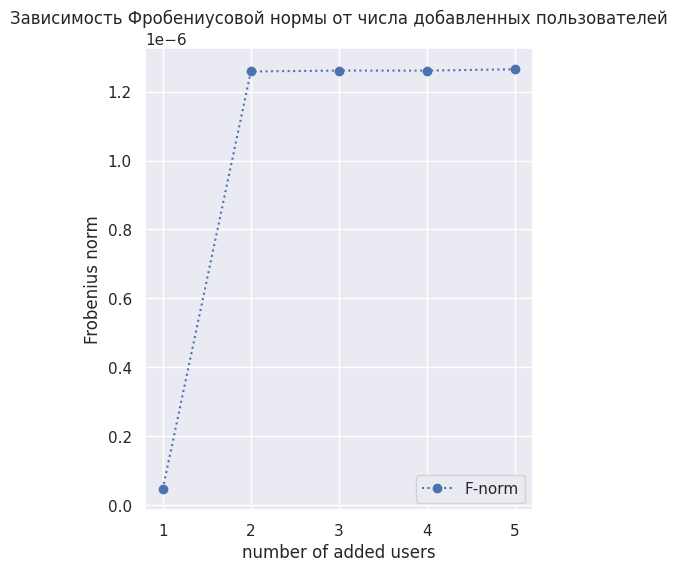

In [ ]:
fig, ax = plt.subplots(figsize=(5,6))
plt.title('Зависимость Фробениусовой нормы от числа добавленных пользователей')
plt.xlabel('number of added users')
plt.ylabel('Frobenius norm')
plt.plot([1, 2, 3, 4, 5], error, ':o', label='F-norm')
plt.legend()
plt.show()

In [ ]:
times = {'svd': [], 'updated': []}
norm = []
for u in range(1, 6): # [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
  users = int(1000 * u)
  explic, explic_removed = remove_users(explicit_filtered_ratings, n = 47537 - users)
  ts_split = {
      "explicit": explic["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets = {}
  for key, dataset in (
      ("explicit", explic),
  ):
      dtsets[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets[key]["valid"] = dtsets[key]["valid"].loc[
          dtsets[key]["valid"].user.isin(dtsets[key]["train"].user.unique())
      ]

  explici = build_sparse_datasets(
    **dtsets["explicit"], binary=False
  )

  explic_minus1, explic_removed_minus1 = remove_users(explicit_filtered_ratings, n = 47537 - users + 1)
  ts_split = {
      "explicit": explic_minus1["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets_minus1 = {}
  for key, dataset in (
      ("explicit", explic_minus1),
  ):
      dtsets_minus1[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets_minus1[key]["valid"] = dtsets_minus1[key]["valid"].loc[
          dtsets_minus1[key]["valid"].user.isin(dtsets_minus1[key]["train"].user.unique())
      ]

  explici_minus1 = build_sparse_datasets(
    **dtsets_minus1["explicit"], binary=False
  )

  runner_ = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
  print('Built-in on minus 1 users')
  runner_.run(explici_minus1)
  times['svd'].append(runner_.model.computation_time)
  runner = SparseRunner(model=Rank_one_SvdModel(runner_.model, add_col = True), batch_size=512, device=device)
  print('Updating SVD')
  runner.run(explici)
  times['updated'].append(runner.model.computation_time)
  norm.append(runner.model.frobenius_norm)

Built-in on minus 1 users
--- 5.6439759731292725 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Updating SVD
--- 0.8736283779144287 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Built-in on minus 1 users
--- 19.62837290763855 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


Updating SVD
--- 3.811082601547241 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Built-in on minus 1 users
--- 56.62812829017639 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


Updating SVD
--- 14.589052438735962 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


Built-in on minus 1 users
--- 130.95230436325073 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


Updating SVD
--- 25.801615715026855 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


Built-in on minus 1 users
--- 181.0248658657074 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Updating SVD
--- 48.2712824344635 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


In [ ]:
times

{'svd': [5.6439759731292725,
  19.62837290763855,
  56.62812829017639,
  130.95230436325073,
  181.0248658657074],
 'updated': [0.8736283779144287,
  3.811082601547241,
  14.589052438735962,
  25.801615715026855,
  48.2712824344635]}

In [ ]:
norm

[2.187549234165168e-08,
 6.923301709567185e-08,
 1.237150138554199e-06,
 8.123158258194033e-07,
 3.1815001459305554e-07]

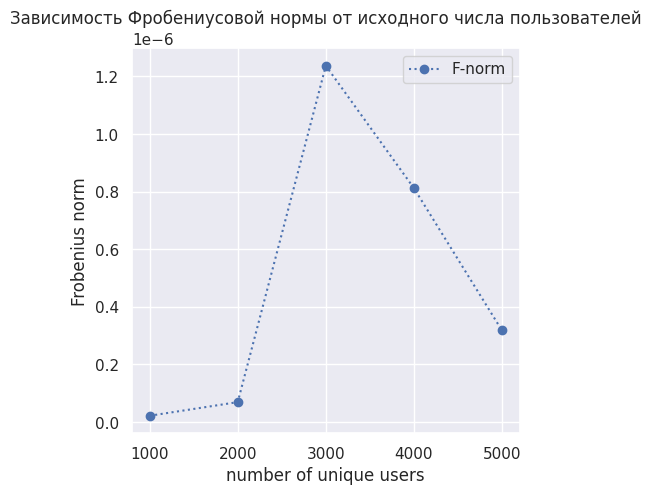

In [ ]:
import matplotlib.pyplot as plt

# full_norm = []
# for i in range(1, 6):
#   full_norm.append(sum(norm[:i]))
fig, ax = plt.subplots(figsize=(5,5))
plt.title('Зависимость Фробениусовой нормы от исходного числа пользователей')
plt.xlabel('number of unique users')
plt.ylabel('Frobenius norm')
plt.plot([1000, 2000, 3000, 4000, 5000], norm, ':o', label='F-norm')
plt.legend()
plt.show()

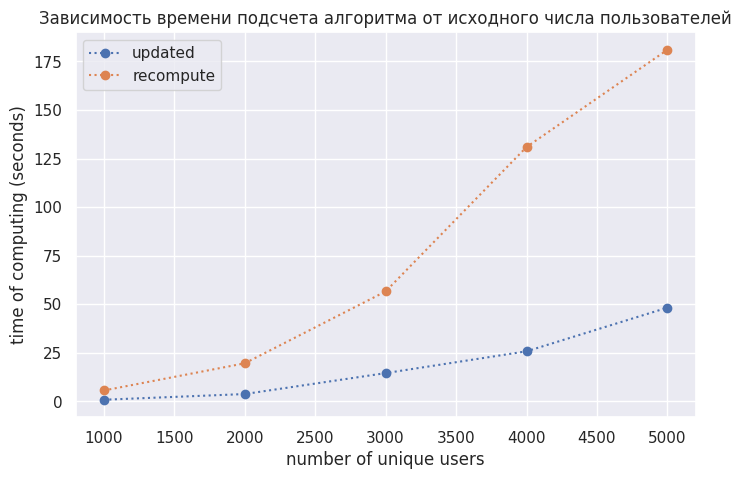

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Зависимость времени подсчета алгоритма от исходного числа пользователей')
plt.xlabel('number of unique users')
plt.ylabel('time of computing (seconds)')
plt.plot([1000, 2000, 3000, 4000, 5000], times['updated'], ':o', label='updated')
plt.plot([1000, 2000, 3000, 4000, 5000], times['svd'], ':o', label='recompute')
plt.legend()
plt.show()

Теперь смотрим на технические метрики, если добавлять айтемы

In [ ]:
explicit_s, explicit_s_removed = remove_users(explicit_filtered_ratings, n = 45537)

Прогоняем 5 раз на разном количестве айтемов (убираем 1-5 айтемов). Сильно тут размер матрицы не меняется, поэтому время +- одинаковое. Пересчет тут скорее нужен для дальнейшего усреднения результатов

In [ ]:
times = {'svd': [], 'updated': []}
norm = []
for i in range(0, 5):
  I = 5 - i
  explic, explic_removed = remove_items(explicit_s, n = 5 - i)
  ts_split = {
      "explicit": explic["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets = {}
  for key, dataset in (
      ("explicit", explic),
  ):
      dtsets[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets[key]["valid"] = dtsets[key]["valid"].loc[
          dtsets[key]["valid"].user.isin(dtsets[key]["train"].user.unique())
      ]

  explici = build_sparse_datasets(
    **dtsets["explicit"], binary=False
  )

  I = 5 - i + 1
  explic_minus1, explic_removed_minus1 = remove_items(explicit_s, n = 5 - i + 1)
  ts_split = {
      "explicit": explic_minus1["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets_minus1 = {}
  for key, dataset in (
      ("explicit", explic_minus1),
  ):
      dtsets_minus1[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets_minus1[key]["valid"] = dtsets_minus1[key]["valid"].loc[
          dtsets_minus1[key]["valid"].user.isin(dtsets_minus1[key]["train"].user.unique())
      ]

  explici_minus1 = build_sparse_datasets(
    **dtsets_minus1["explicit"], binary=False
  )

  runner_ = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
  print('Built-in on minus 1 users')
  runner_.run(explici_minus1)
  times['svd'].append(runner_.model.computation_time)
  runner = SparseRunner(model=Rank_one_SvdModel(runner_.model, add_col = False), batch_size=512, device=device)
  print('Updating SVD')
  runner.run(explici)
  times['updated'].append(runner.model.computation_time)
  norm.append(runner.model.frobenius_norm)

Built-in on minus 1 users
--- 42.68930101394653 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


Updating SVD
--- 6.780508518218994 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Built-in on minus 1 users
--- 35.43335318565369 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Updating SVD
--- 9.17720627784729 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


Built-in on minus 1 users
--- 35.02480411529541 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


Updating SVD
--- 8.262252569198608 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Built-in on minus 1 users
--- 23.722098112106323 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Updating SVD
--- 5.397979021072388 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Built-in on minus 1 users
--- 38.60447096824646 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Updating SVD
--- 4.244108438491821 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


In [ ]:
times

{'svd': [42.68930101394653,
  35.43335318565369,
  35.02480411529541,
  23.722098112106323,
  38.60447096824646],
 'updated': [6.780508518218994,
  9.17720627784729,
  8.262252569198608,
  5.397979021072388,
  4.244108438491821]}

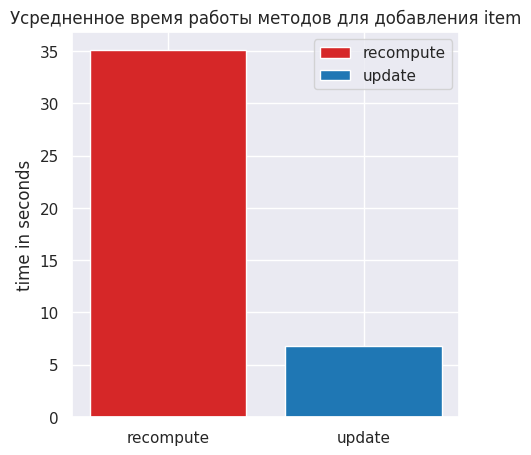

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

methods = ['recompute', 'update']
counts = [sum(times['svd']) / 5, sum(times['updated']) / 5]
bar_labels = ['recompute', 'update']
bar_colors = ['tab:red', 'tab:blue']

ax.bar(methods, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('time in seconds')
ax.set_title('Усредненное время работы методов для добавления item')
ax.legend()
plt.show()

In [ ]:
times = {'svd': [], 'updated': []}
norm = []
for i in range(0, 5):
  I = 2500 - i * 500
  explic, explic_removed = remove_items(explicit_s, n = 2500 - i * 500)
  ts_split = {
      "explicit": explic["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets = {}
  for key, dataset in (
      ("explicit", explic),
  ):
      dtsets[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets[key]["valid"] = dtsets[key]["valid"].loc[
          dtsets[key]["valid"].user.isin(dtsets[key]["train"].user.unique())
      ]

  explici = build_sparse_datasets(
    **dtsets["explicit"], binary=False
  )

  I = 2500 - i * 500 + 1
  explic_minus1, explic_removed_minus1 = remove_items(explicit_s, n = 2500 - i * 500 + 1)
  ts_split = {
      "explicit": explic_minus1["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets_minus1 = {}
  for key, dataset in (
      ("explicit", explic_minus1),
  ):
      dtsets_minus1[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets_minus1[key]["valid"] = dtsets_minus1[key]["valid"].loc[
          dtsets_minus1[key]["valid"].user.isin(dtsets_minus1[key]["train"].user.unique())
      ]

  explici_minus1 = build_sparse_datasets(
    **dtsets_minus1["explicit"], binary=False
  )

  runner_ = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
  print('Built-in on minus 1 users')
  runner_.run(explici_minus1)
  times['svd'].append(runner_.model.computation_time)
  runner = SparseRunner(model=Rank_one_SvdModel(runner_.model, add_col = False), batch_size=512, device=device)
  print('Updating SVD')
  runner.run(explici)
  times['updated'].append(runner.model.computation_time)
  norm.append(runner.model.frobenius_norm)

Built-in on minus 1 users
--- 20.628633975982666 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]


Updating SVD
--- 4.4922935962677 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


Built-in on minus 1 users
--- 21.28618550300598 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


Updating SVD
--- 3.577878952026367 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Built-in on minus 1 users
--- 17.79463291168213 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


Updating SVD
--- 4.327920913696289 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]


Built-in on minus 1 users
--- 17.976313591003418 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Updating SVD
--- 4.059778928756714 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


Built-in on minus 1 users
--- 19.371697664260864 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Updating SVD
--- 5.293236494064331 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


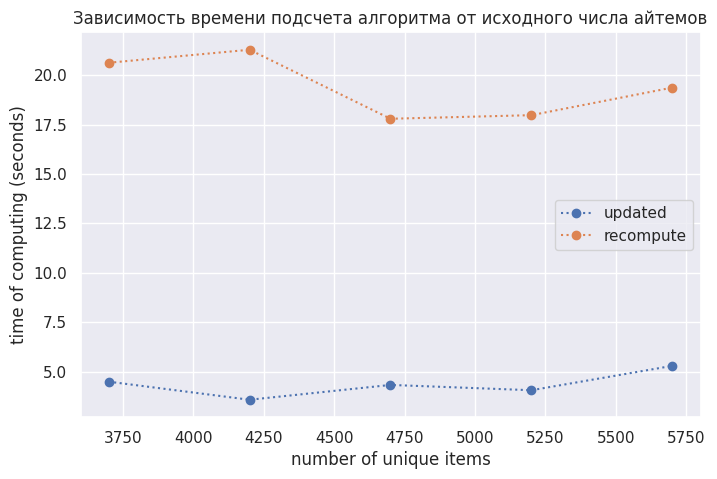

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Зависимость времени подсчета алгоритма от исходного числа айтемов')
plt.xlabel('number of unique items')
plt.ylabel('time of computing (seconds)')
plt.plot([3700, 4200, 4700, 5200, 5700], times['updated'], ':o', label='updated')
plt.plot([3700, 4200, 4700, 5200, 5700], times['svd'], ':o', label='recompute')
plt.legend()
plt.show()

### Test of svd updating algorithm

Технический раздел. Использовался во время разработки методов

In [46]:
def generate_matrix(m, n):
    A = np.random.randn(m, n)
    return A

def add_column_or_row(A, is_column=True):
    if is_column:
        new_col = np.random.randn(A.shape[0])
        return np.c_[A, new_col]
    else:
        new_row = np.random.randn(A.shape[1])
        return np.r_[A, [new_row]]

# Main testing function
def test_update_svd(m, n, add_col=True):
    """
    Тестируем и сравниваем.
    """
    # СВД для случайной матрицы
    A = generate_matrix(m, n)
    start_time = time.time()
    U, S, Vh = la.svd(A, full_matrices=False)
    svd_time = time.time() - start_time

    # Добавляем колонку (или строку)
    if add_col:
        print("Была добавлена колонка")
        A_expanded = add_column_or_row(A, is_column=True)
    else:
        print("Была добавлена строка")
        A_expanded = add_column_or_row(A, is_column=False)

    # Обновляем СВД модицированным методом
    new_col_or_row = A_expanded[:, -1] if add_col else A_expanded[-1, :]
    start_time = time.time()
    print(U.shape, S.shape, Vh.shape, new_col_or_row.shape)
    U_updated, S_updated, Vh_updated = update_SVD(U, S, Vh, new_col_or_row, a_col_col=add_col)
    update_time = time.time() - start_time

    # Пересчитываем наивным методом
    start_time = time.time()
    U_recomp, S_recomp, Vh_recomp = la.svd(A_expanded, full_matrices=False)
    recompute_time = time.time() - start_time

    # Верифицируем результаты
    reconstruction = U_updated @ np.diag(S_updated) @ Vh_updated
    difference = A_expanded - reconstruction
    frobenius_norm = np.linalg.norm(difference, 'fro')

    # Тайминги
    print(f"SVD computation time: {svd_time:.6f} seconds")
    print(f"SVD update time: {update_time:.6f} seconds")
    print(f"SVD recompute time: {recompute_time:.6f} seconds")

    print(f'The Frobenius norm : {frobenius_norm}')
    if update_time < recompute_time:
        print("Updating SVD is faster than recomputing.")
    else:
        print("Recomputing SVD is faster than updating.")
    return update_time, recompute_time

In [ ]:
update_time, recompute_time = test_update_svd(10000, 800, add_col=True)  # Добавление колонки
update_time, recompute_time = test_update_svd(10000, 800, add_col=False) # Добавление строки

Была добавлена колонка
(10000, 800) (800,) (800, 800) (10000,)
SVD computation time: 2.746658 seconds
SVD update time: 0.828837 seconds
SVD recompute time: 3.497359 seconds
The Frobenius norm : 1.332841528517169e-07
Updating SVD is faster than recomputing.
Была добавлена строка
(10000, 800) (800,) (800, 800) (800,)
SVD computation time: 2.750916 seconds
SVD update time: 0.789416 seconds
SVD recompute time: 2.766456 seconds
The Frobenius norm : 1.3847548481220142e-06
Updating SVD is faster than recomputing.


In [47]:
times = {'svd': [], 'updated': []}
for num_items in [500, 1500, 2500, 3500, 4500]:
  update_time, recompute_time = test_update_svd(5000, num_items, add_col=True)  # Добавление колонки
  times['svd'].append(recompute_time)
  times['updated'].append(update_time)

Была добавлена колонка
(5000, 500) (500,) (500, 500) (5000,)
SVD computation time: 0.683853 seconds
SVD update time: 0.198480 seconds
SVD recompute time: 0.872888 seconds
The Frobenius norm : 9.857980735612017e-08
Updating SVD is faster than recomputing.
Была добавлена колонка
(5000, 1500) (1500,) (1500, 1500) (5000,)
SVD computation time: 4.803746 seconds
SVD update time: 1.413606 seconds
SVD recompute time: 4.398730 seconds
The Frobenius norm : 1.2224759695553422e-06
Updating SVD is faster than recomputing.
Была добавлена колонка
(5000, 2500) (2500,) (2500, 2500) (5000,)
SVD computation time: 16.342351 seconds
SVD update time: 4.487896 seconds
SVD recompute time: 17.147226 seconds
The Frobenius norm : 5.824124206014626e-06
Updating SVD is faster than recomputing.
Была добавлена колонка
(5000, 3500) (3500,) (3500, 3500) (5000,)
SVD computation time: 44.382133 seconds
SVD update time: 11.430849 seconds
SVD recompute time: 45.146305 seconds
The Frobenius norm : 1.2012546350861194e-06
Up

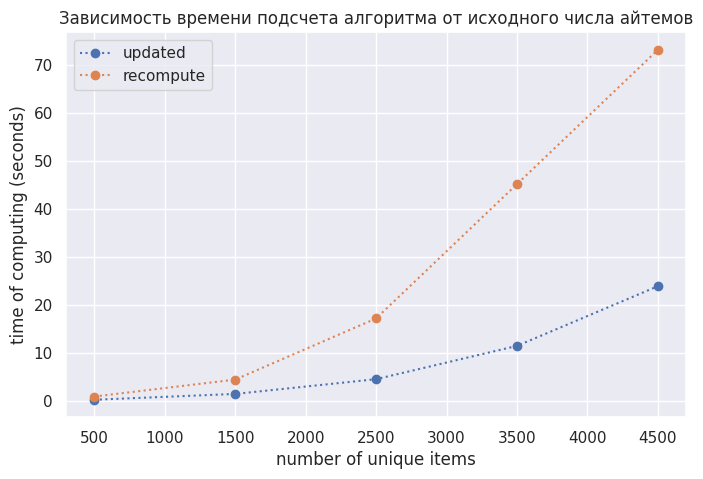

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5))
plt.title('Зависимость времени подсчета алгоритма от исходного числа айтемов')
plt.xlabel('number of unique items')
plt.ylabel('time of computing (seconds)')
plt.plot([500, 1500, 2500, 3500, 4500], times['updated'], ':o', label='updated')
plt.plot([500, 1500, 2500, 3500, 4500], times['svd'], ':o', label='recompute')
plt.legend()
plt.show()

## 5. Evaluation

$target_{sort}$ — таргет, сортированный в соответствии с логитами модели по убыванию.

Так как мы всё делаем через animus, сделаем второй callback, чтобы красиво визуализировать метрики моделей.

In [ ]:
class MetricCallback(ICallback):
    def __init__(self, func: Callable, topk: list[int], input_key: str) -> None:
        self._name = func.__name__
        self._func = func
        self._topk = topk
        self._input_key = input_key
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def _get_metric(self) -> dict[str, float]:
        return {
            f"{self._name}@{k}": metric_sum / self._num_batches
            for k, metric_sum in self._total_sum.items()
        }

    def on_dataset_start(self, exp: IExperiment) -> None:
        self._total_sum = {k: 0 for k in self._topk}
        self._num_batches = 0

    def on_batch_end(self, exp: IExperiment) -> None:
        for k in self._topk:
            self._total_sum[k] += self._func(
                exp.batch_output[self._input_key], exp.batch_target, topk=k
            ).item()
        self._num_batches += 1
        exp.batch_metrics.update(self._get_metric())

    def on_dataset_end(self, exp: IExperiment) -> None:
        exp.dataset_metrics.update(self._get_metric())

In [ ]:
class LoggerCallback(ICallback):
    def on_dataset_end(self, exp: IExperiment) -> None:
        """Run callbacks on dataset end."""
        print(f"{exp.dataset_key.capitalize()} metrics:")
        max_length = max(len(x) for x in exp.dataset_metrics)
        # Sort by length to make it prettier
        for metric in sorted(exp.dataset_metrics, key=self._sort_func):
            metric_value = exp.dataset_metrics.get(metric)
            if isinstance(metric_value, (float, int)):
                print(f"{metric.ljust(max_length)} | {metric_value:.4f}")

    @staticmethod
    def _sort_func(x: str) -> Tuple[int, str, int]:
        if "@" in x:
            metric_key, topk = x.split("@")
            return (len(metric_key), metric_key, int(topk))
        return (len(x), x, 0)

In [ ]:
class PrepareTargetResult(NamedTuple):
    values: torch.Tensor
    indices: torch.Tensor


def validate_metric_inputs(output: torch.Tensor, target: torch.Tensor) -> None:
    if output.size() != target.size():
        raise IndexError(
            "Unequal sizes for output and target: "
            f"output - {output.size()}, target - {target.size()}."
        )
    if not (target.eq(0) | target.eq(1)).all():
        raise ValueError(
            "Target contains values outside of 0 and 1." f"\nTarget:\n{target}"
        )


def prepare_target(
    output: torch.Tensor, target: torch.Tensor, return_indices: bool = False
) -> Union[torch.Tensor, PrepareTargetResult]:
    validate_metric_inputs(output, target)
    # Define order by sorted output scores.
    indices = output.argsort(dim=-1, descending=True)
    sorted_target = torch.gather(target, index=indices, dim=-1)
    return (
        PrepareTargetResult(sorted_target, indices) if return_indices else sorted_target
    )


def nan_to_num(tensor: torch.Tensor, nan: float = 0.0) -> torch.Tensor:
    return torch.where(
        torch.isnan(tensor) | torch.isinf(tensor),
        torch.full_like(tensor, fill_value=nan),
        tensor,
    )

In [ ]:
output, target = (
    torch.randn(size=(10, 13)),
    torch.randint(low=0, high=2, size=(10, 13)).float(),
)

### 5.1 Precision

$$
p@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{k}
$$

In [ ]:
def precision(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # precision_score ~ (users)
    precision_score = target_sorted_by_output.sum(dim=-1) / topk
    return precision_score.mean()

In [ ]:
precision(output, target, topk=3)

tensor(0.4667)

### 5.2 Recall

$$
r@k = \frac{\sum_{i=1}^{k}target_{sort}[i]}{\sum target}
$$

In [ ]:
def recall(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.shape[-1], topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # recall_score ~ (users)
    recall_score = nan_to_num(target_sorted_by_output.sum(dim=-1) / target.sum(dim=-1))
    return recall_score.mean()

In [ ]:
recall(output, target, topk=3)

tensor(0.2017)

### 5.3 Mean (Normalized) Average Precision

$ap@k = \frac{1}{\sum_{i=1}^k{target_{sort}[i]}} \sum_{i=1}^k target_{sort}[i] \cdot p@i$
```python
map@k = reduce(ap@k, "users->", reduction="mean")
```

In [ ]:
def mnap(
    output: torch.Tensor, target: torch.Tensor, topk: int, normalized: bool = True
) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, topk)
    target_sorted_by_output = prepare_target(output, target)[:, :topk]
    # target_cumsum ~ (users, topk)
    target_cumsum = target_sorted_by_output.cumsum(dim=-1)
    # topk_tensor ~ (topk)
    topk_tensor = torch.arange(0, topk, dtype=torch.long, device=output.device)
    # precisions ~ (users, topk)
    precisions = target_cumsum / (topk_tensor + 1.0)
    # relevant_precisions ~ (users, topk)
    relevant_precisions = precisions * target_sorted_by_output
    # Add  normalization if needed
    denominator = (
        target.sum(dim=-1).clamp(max=topk)
        if normalized
        else target_sorted_by_output.sum(dim=-1)
    )
    # ap_score ~ (users)
    ap_score = nan_to_num(relevant_precisions.sum(dim=-1) / denominator)
    return ap_score.mean()

In [ ]:
mnap(output, target, topk=3)

tensor(0.3556)

### 5.4 Normalized Discounted Cumulative Gain

- Cumulative Gain (CG): $CG@k = \sum_{i=1}^k target_{sort}[i]$
- Discounted Cumulative Gain (DCG): $DCG@k = \sum_{i=1}^k \frac{2^{target_{sort}[i]} - 1}{\log(i + 1)}$
- Normalized Discounted Cumulative Gain (nDCG): $nDCG@k = \frac{DCG@k}{idealDCG@k}$

In [ ]:
def dcg(tensor: torch.Tensor) -> torch.Tensor:
    gains = (2**tensor) - 1
    return gains / torch.log2(
        torch.arange(0, tensor.size(-1), dtype=torch.float, device=tensor.device) + 2.0
    )


def ndcg(output: torch.Tensor, target: torch.Tensor, topk: int) -> torch.Tensor:
    topk = min(output.size(-1), topk)
    # target_sorted_by_output ~ (users, items)
    target_sorted_by_output = prepare_target(output, target)
    ideal_target = prepare_target(target, target)
    # ideal_dcg ~ (users, topk)
    ideal_dcg = dcg(ideal_target)[:, :topk]
    # prediction_dcg ~ (users, topk)
    prediction_dcg = dcg(target_sorted_by_output)[:, :topk]
    # ideal_dcg_cumsum ~ (users)
    ideal_dcg_score = ideal_dcg.sum(dim=-1)
    # prediction_dcg_cumsum ~ (users)
    prediction_dcg_score = prediction_dcg.sum(dim=-1)
    # ndcg_score ~ (users, items)
    ndcg_score = nan_to_num(prediction_dcg_score / ideal_dcg_score)
    # ndcg_score[ideal_dcg_score.eq(0)] = 0.0
    return ndcg_score.mean()

In [ ]:
ndcg(output, target, topk=3)

tensor(0.4531)

#### Compute metrics

In [ ]:
# Будем смотреть на метрики только на train-е, т.к. valid выборка очень маленькая

runner_ = SparseRunner(
    model=Built_in_SvdModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner_.run(explicit_small_datasets_minus1)

runner = SparseRunner(
    model=Rank_one_SvdModel(runner_.model),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner.run(explicit_small_datasets)

--- 172.18837118148804 seconds svd computation---


Iterating train: 100%|██████████| 10/10 [01:37<00:00,  9.72s/it]


Train metrics:
mnap@1       | 0.9841
mnap@3       | 0.9841
mnap@10      | 0.9841
ndcg@1       | 0.9841
ndcg@3       | 0.9841
ndcg@10      | 0.9841
recall@1     | 0.0980
recall@3     | 0.2328
recall@10    | 0.5118
precision@1  | 0.9841
precision@3  | 0.9611
precision@10 | 0.8720


Iterating valid: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]


Valid metrics:
mnap@1       | 0.0000
mnap@3       | 0.0000
mnap@10      | 0.0000
ndcg@1       | 0.0000
ndcg@3       | 0.0000
ndcg@10      | 0.0000
recall@1     | 0.0000
recall@3     | 0.0000
recall@10    | 0.0000
precision@1  | 0.0000
precision@3  | 0.0000
precision@10 | 0.0000
--- 46.48528599739075 seconds svd computation---


Iterating train: 100%|██████████| 10/10 [01:38<00:00,  9.84s/it]


Train metrics:
mnap@1       | 0.9843
mnap@3       | 0.9843
mnap@10      | 0.9843
ndcg@1       | 0.9843
ndcg@3       | 0.9843
ndcg@10      | 0.9843
recall@1     | 0.0981
recall@3     | 0.2327
recall@10    | 0.5120
precision@1  | 0.9843
precision@3  | 0.9611
precision@10 | 0.8723


Iterating valid: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]

Valid metrics:
mnap@1       | 0.0000
mnap@3       | 0.0000
mnap@10      | 0.0000
ndcg@1       | 0.0000
ndcg@3       | 0.0000
ndcg@10      | 0.0000
recall@1     | 0.0000
recall@3     | 0.0000
recall@10    | 0.0000
precision@1  | 0.0000
precision@3  | 0.0000
precision@10 | 0.0000


In [ ]:
runner_ = SparseRunner(
    model=Built_in_SvdModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner_.run(explicit_small_datasets)

--- 186.06598281860352 seconds svd computation---


Iterating train: 100%|██████████| 10/10 [01:40<00:00, 10.09s/it]


Train metrics:
mnap@1       | 0.9843
mnap@3       | 0.9843
mnap@10      | 0.9843
ndcg@1       | 0.9843
ndcg@3       | 0.9843
ndcg@10      | 0.9843
recall@1     | 0.0981
recall@3     | 0.2327
recall@10    | 0.5120
precision@1  | 0.9843
precision@3  | 0.9611
precision@10 | 0.8723


Iterating valid: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]

Valid metrics:
mnap@1       | 0.0000
mnap@3       | 0.0000
mnap@10      | 0.0000
ndcg@1       | 0.0000
ndcg@3       | 0.0000
ndcg@10      | 0.0000
recall@1     | 0.0000
recall@3     | 0.0000
recall@10    | 0.0000
precision@1  | 0.0000
precision@3  | 0.0000
precision@10 | 0.0000


In [ ]:
runner_ = SparseRunner(
    model=TopPopularModel(),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
runner_.run(explicit_small_datasets)

Iterating train: 100%|██████████| 10/10 [00:40<00:00,  4.07s/it]


Train metrics:
mnap@1       | 0.3971
mnap@3       | 0.3214
mnap@10      | 0.2085
ndcg@1       | 0.3971
ndcg@3       | 0.3842
ndcg@10      | 0.3181
recall@1     | 0.0150
recall@3     | 0.0439
recall@10    | 0.0953
precision@1  | 0.3971
precision@3  | 0.3771
precision@10 | 0.2835


Iterating valid: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

Valid metrics:
mnap@1       | 0.0000
mnap@3       | 0.0000
mnap@10      | 0.0000
ndcg@1       | 0.0000
ndcg@3       | 0.0000
ndcg@10      | 0.0000
recall@1     | 0.0000
recall@3     | 0.0000
recall@10    | 0.0000
precision@1  | 0.0000
precision@3  | 0.0000
precision@10 | 0.0000


In [ ]:
# error = []
# reconstr = []
# true_mat = []

explic_minus5, explic_removed_minus5 = remove_users(explicit_filtered_ratings, n = 47537 - 5000 + 5)
ts_split = {
    "explicit": explic_minus5["timestamp"].max()
    - pd.Timedelta(165, "days"),
}
dtsets_minus5 = {}
for key, dataset in (
    ("explicit", explic_minus5),
):
    dtsets_minus5[key] = {
        "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
        "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
    }
    dtsets_minus5[key]["valid"] = dtsets_minus5[key]["valid"].loc[
        dtsets_minus5[key]["valid"].user.isin(dtsets_minus5[key]["train"].user.unique())
    ]

explici_minus5 = build_sparse_datasets(
  **dtsets_minus5["explicit"], binary=False
)

runner_ = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
print('Built-in on minus 5 users')
runner_.run(explici_minus5)
modl = runner_.model

for u in range(1, 6):
  print('u = ', u)
  users = 5000
  explic, explic_removed = remove_users(explicit_filtered_ratings, n = 47537 - users + 5 - u)
  ts_split = {
      "explicit": explic["timestamp"].max()
      - pd.Timedelta(165, "days"),
  }
  dtsets = {}
  for key, dataset in (
      ("explicit", explic),
  ):
      dtsets[key] = {
          "train": dataset.loc[dataset["timestamp"] <= ts_split[key]],
          "valid": dataset.loc[dataset["timestamp"] > ts_split[key]],
      }
      dtsets[key]["valid"] = dtsets[key]["valid"].loc[
          dtsets[key]["valid"].user.isin(dtsets[key]["train"].user.unique())
      ]

  explici = build_sparse_datasets(
    **dtsets["explicit"], binary=False
  )

  runner = SparseRunner(
    model=Rank_one_SvdModel(runner_.model),
    batch_size=512,
    callbacks={
        "precision": MetricCallback(precision, input_key="logits", topk=(1, 3, 10)),
        "recall": MetricCallback(recall, input_key="logits", topk=(1, 3, 10)),
        "ndcg": MetricCallback(ndcg, input_key="logits", topk=(1, 3, 10)),
        "map": MetricCallback(mnap, input_key="logits", topk=(1, 3, 10)),
        "logger": LoggerCallback(),
    },
    target_threshold=3.0,
    device=device,
)
  print('Updating SVD')
  runner.run(explici)
  U_updated, S_updated, Vh_updated = runner.model.svd
  reconstr.append(U_updated @ np.diag(S_updated) @ Vh_updated)
  modl = runner.model

  runner = SparseRunner(model=Built_in_SvdModel(), batch_size=512, device=device)
  runner.run(explici)
  print('Recomputing SVD')
  runner.run(explici)
  U, S, Vh = runner.model.svd
  true_mat.append(U @ np.diag(S) @ Vh)

  # difference = true_mat[u - 1] - reconstr[u - 1]
  # frobenius_norm = np.linalg.norm(difference, 'fro')
  # print('Error:' + str(frobenius_norm))
  # error.append(frobenius_norm)

Built-in on minus 5 users
--- 179.72671723365784 seconds svd computation---


Iterating valid: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


u =  1
Updating SVD
--- 46.365488052368164 seconds svd computation---


Iterating train: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]


Train metrics:
mnap@1       | 0.9843
mnap@3       | 0.9843
mnap@10      | 0.9843
ndcg@1       | 0.9843
ndcg@3       | 0.9843
ndcg@10      | 0.9843
recall@1     | 0.0982
recall@3     | 0.2326
recall@10    | 0.5115
precision@1  | 0.9843
precision@3  | 0.9610
precision@10 | 0.8725


Iterating valid: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


Valid metrics:
mnap@1       | 0.0000
mnap@3       | 0.0000
mnap@10      | 0.0000
ndcg@1       | 0.0000
ndcg@3       | 0.0000
ndcg@10      | 0.0000
recall@1     | 0.0000
recall@3     | 0.0000
recall@10    | 0.0000
precision@1  | 0.0000
precision@3  | 0.0000
precision@10 | 0.0000
